# Calidad y limpieza

## Exploración de distribuciones

In [1]:
# Carga de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder


In [2]:
# Carga de datos. 
df = pd.read_excel('/Users/luciafrailemorera/00_TFM/Dataset_imagenes_validas.xlsx')

In [3]:
df.head()

id gender masterCategory subCategory  articleType baseColour  season  \
0  15970    Men        Apparel     Topwear       Shirts  Navy Blue    Fall   
1  21379    Men        Apparel  Bottomwear  Track Pants      Black    Fall   
2   1855    Men        Apparel     Topwear      Tshirts       Grey  Summer   
3  18653    Men       Footwear  Flip Flops   Flip Flops      Black    Fall   
4  12369    Men        Apparel     Topwear       Shirts     Purple    Fall   

   year   usage                             productDisplayName  
0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1  2011  Casual  Manchester United Men Solid Black Track Pants  
2  2011  Casual           Inkfruit Mens Chain Reaction T-shirt  
3  2011  Casual              Fila Men Cush Flex Black Slippers  
4  2011  Formal          Reid & Taylor Men Check Purple Shirts

# Exploración del dataset

Para comenzar, exploramos el dataset: cuantas muestras tiene, cuantas columnas y de que tipo.

In [4]:
df.shape

(13746, 10)

In [5]:
df.dtypes

id                     int64
gender                object
masterCategory        object
subCategory           object
articleType           object
baseColour            object
season                object
year                   int64
usage                 object
productDisplayName    object
dtype: object

Verificamos que los formatos de datos son correctos, y corregimos donde es necesario. 

In [6]:
df.select_dtypes("object").head()

gender masterCategory subCategory  articleType baseColour  season   usage  \
0    Men        Apparel     Topwear       Shirts  Navy Blue    Fall  Casual   
1    Men        Apparel  Bottomwear  Track Pants      Black    Fall  Casual   
2    Men        Apparel     Topwear      Tshirts       Grey  Summer  Casual   
3    Men       Footwear  Flip Flops   Flip Flops      Black    Fall  Casual   
4    Men        Apparel     Topwear       Shirts     Purple    Fall  Formal   

                              productDisplayName  
0               Turtle Check Men Navy Blue Shirt  
1  Manchester United Men Solid Black Track Pants  
2           Inkfruit Mens Chain Reaction T-shirt  
3              Fila Men Cush Flex Black Slippers  
4          Reid & Taylor Men Check Purple Shirts

In [7]:
#Pasamos de tipo object a tipo string
df_objects_as_strings = df.select_dtypes("object").astype(pd.StringDtype())

In [8]:
df_objects_as_strings.dtypes

gender                string[python]
masterCategory        string[python]
subCategory           string[python]
articleType           string[python]
baseColour            string[python]
season                string[python]
usage                 string[python]
productDisplayName    string[python]
dtype: object

In [9]:
#asignamos las nuevas columnas al dataframe original
df = df.assign(**df_objects_as_strings) # aquí aplicamos assign con "automatic unpacking" sobre las variables del dataframe
# Automatic unpacking : https://python-reference.readthedocs.io/en/latest/docs/operators/dict_unpack.html

In [10]:
df.dtypes

id                             int64
gender                string[python]
masterCategory        string[python]
subCategory           string[python]
articleType           string[python]
baseColour            string[python]
season                string[python]
year                           int64
usage                 string[python]
productDisplayName    string[python]
dtype: object

In [ ]:
#En cuanto a formatos, solo quedaría pasar el año de float a date, si fuese necesario.
date_format = '%Y'
date_obj = dt.strptime(df.year, date_format)
print(date_obj)

# Valores nulos (*missing*)

In [11]:
columns_with_nulls = df.isna().sum().sort_values(ascending=False)
columns_with_nulls = columns_with_nulls[columns_with_nulls>0]
columns_with_nulls

usage         11
baseColour     3
dtype: int64

Exploramos ahora los nulos por muestras, aplicando `.sum(axis=1)`.

In [12]:
df.isna().sum(axis=1).sort_values(ascending=False).head(10)

3921     1
8676     1
3234     1
11877    1
1874     1
3464     1
4658     1
11928    1
6236     1
12222    1
dtype: int64

Y comprobamos que es lo más habitual

In [13]:
df.isna().sum(axis=1).value_counts()

0    13732
1       14
Name: count, dtype: int64

## Inputación de nulos

Para los nulos, hemos eligido el enfoque entre los siguientes al ser en variables categoricas (variables usage y baseColour):
1. Imputar a través de un modelo que infiera los datos desde las imagenes.
2. Eliminar los registros con nulos. 
Al ser un dataset complementario al de las imagenes (tiene información propia de la imagen), hemos decidido no utilizar ni la media/mediana u otros estadistiticos ya que puede contradecir completamente el valor real de esa variable. Como son solo 14 registros y contamos con más de 13.000 (masa muestral suficiente), se ha decidido eliminar los registros nulos.

In [14]:
data_cleaned = df.dropna()

In [15]:
data_cleaned.shape

(13732, 10)

In [16]:
columns_with_nulls = data_cleaned.isna().sum().sort_values(ascending=False)
columns_with_nulls = columns_with_nulls[columns_with_nulls>0]
columns_with_nulls

Series([], dtype: int64)

Vemos que se han eliminado las muestras con valores nulos, vamos a guardarlo en un excel para compartir el fichero y así cruzarlo con las imagenes y eliminar las no aptas. 

In [17]:
data_cleaned.to_excel('dataset_wo_nulos.xlsx', index = False)

# Analisis exploratorio

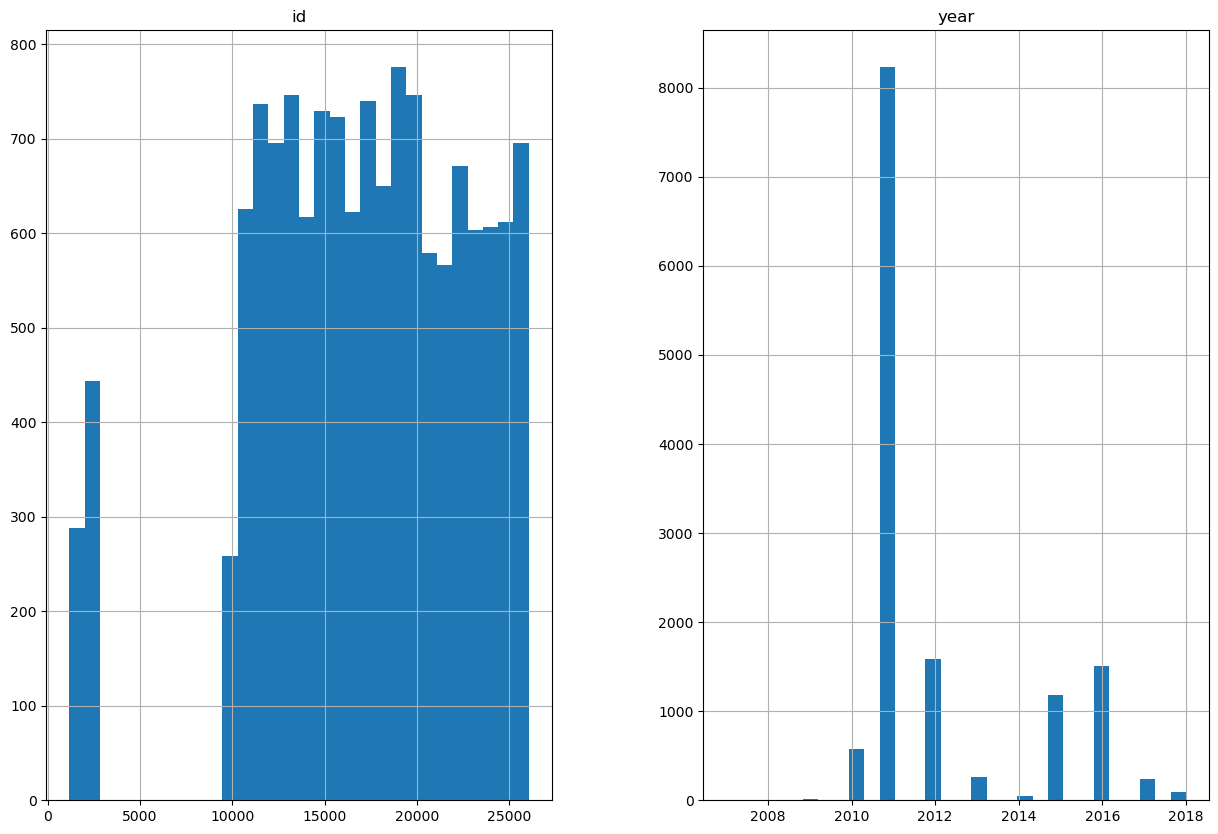

In [18]:
data_cleaned.hist(bins=30, figsize=(15, 10))
plt.show()


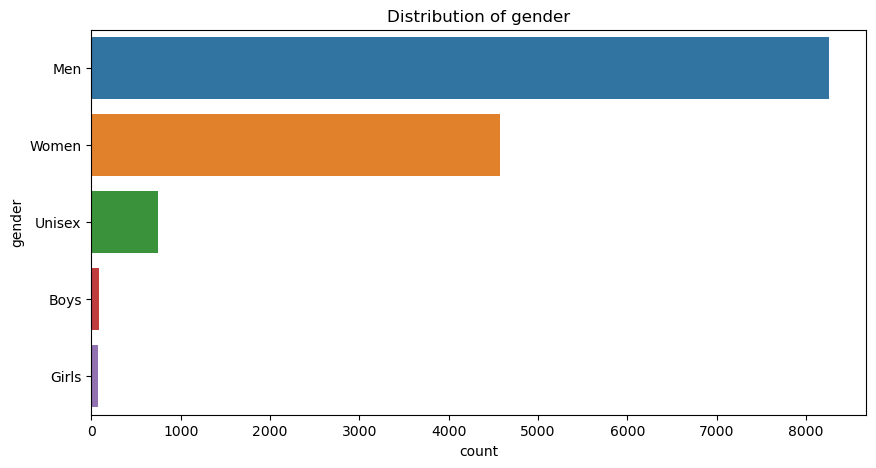

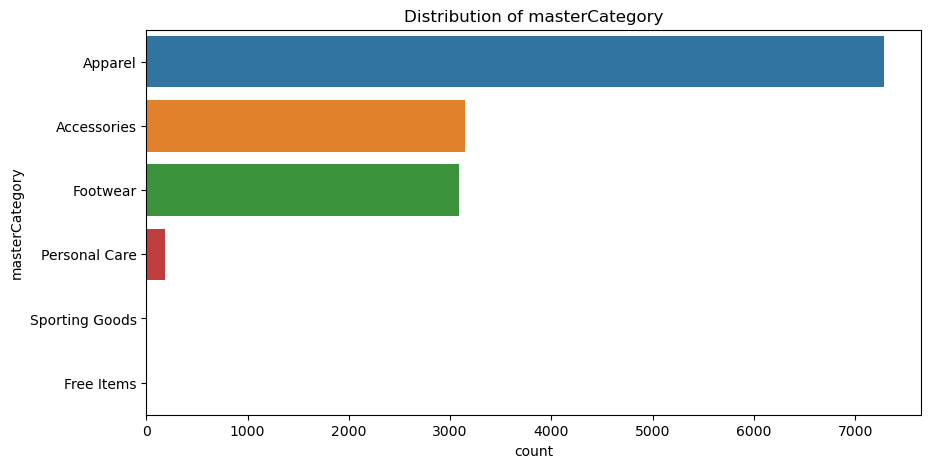

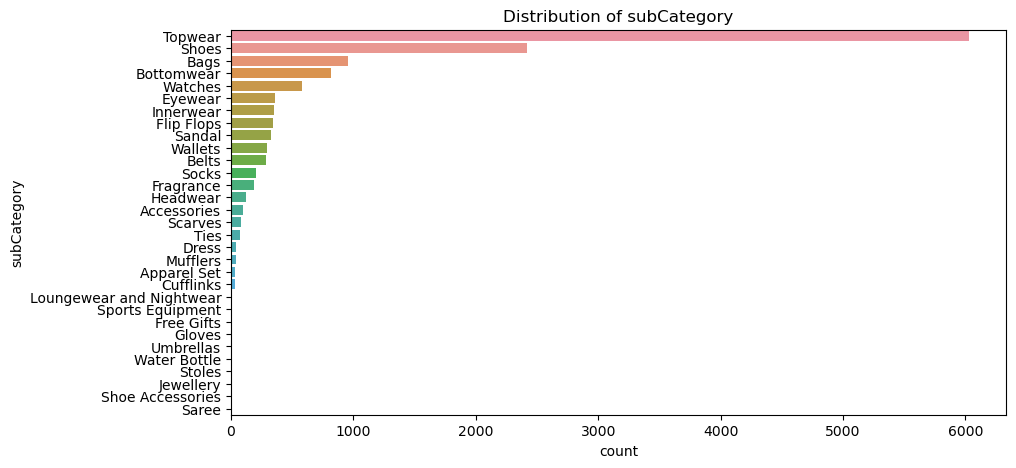

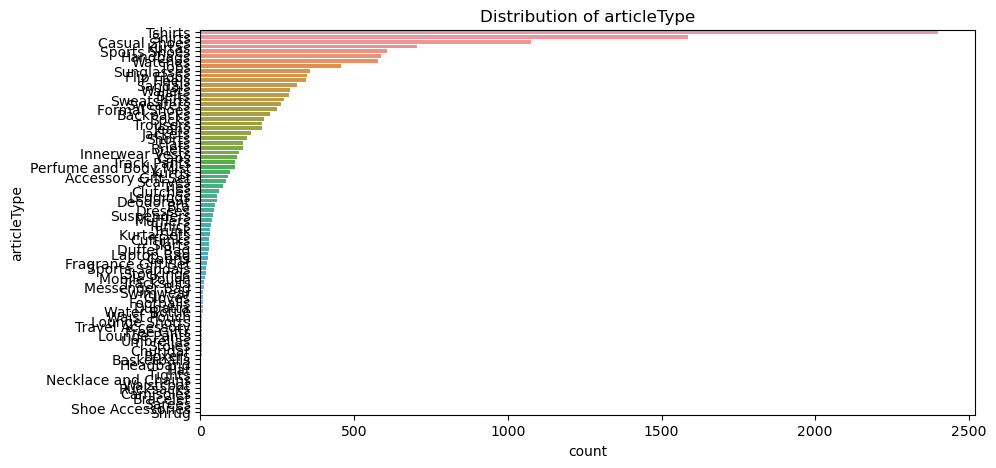

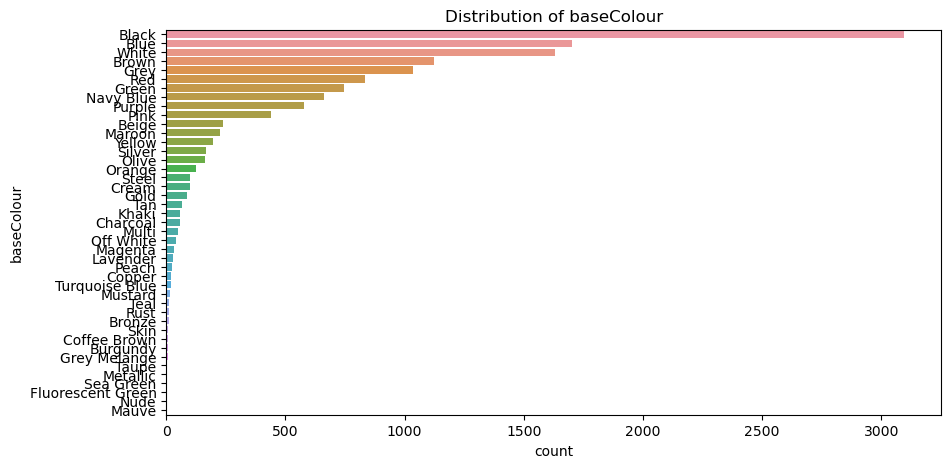

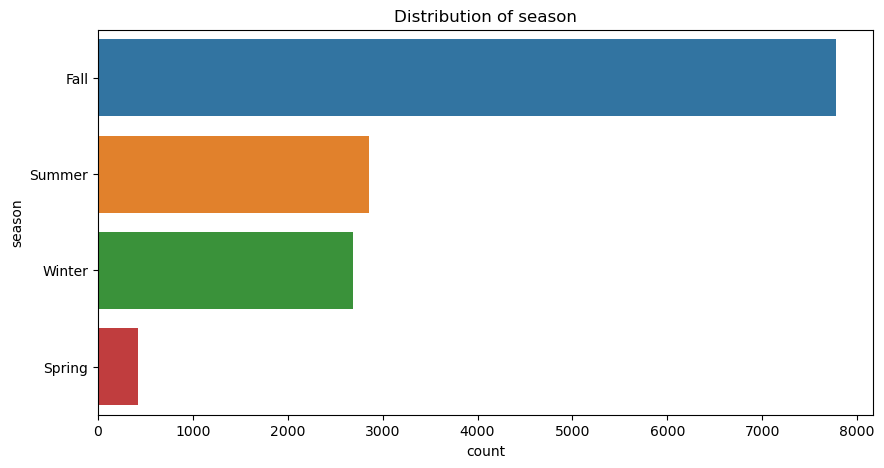

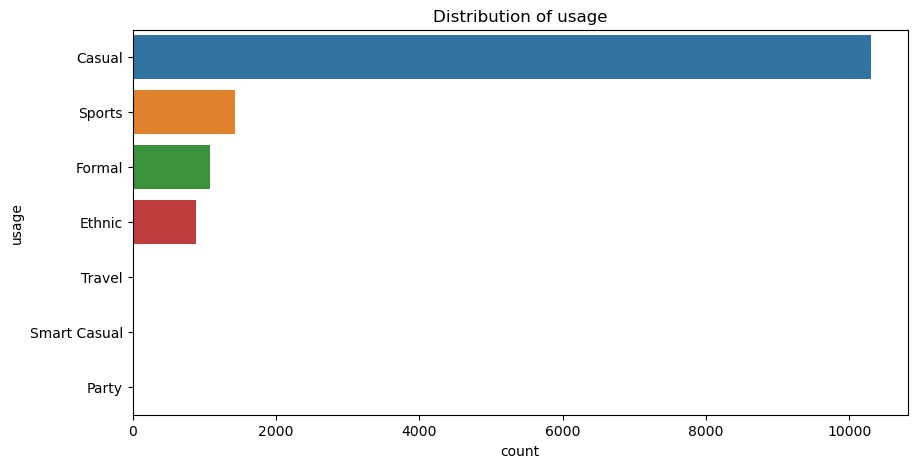

In [19]:
#Gráfico de barras para variables categóricas
categorical_cols = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour','season','usage']
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(y=col, data=data_cleaned, order = data_cleaned[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.show()
    


Para las variables categóricas:
1. Para el caso del genero, vamos a numerizar los registros. Men será 1, Women 2, Unisex 3, Boys 4 y Girls 5. A lo mejor boys y girls lo metemos en un unico grupo de hombres. 
2. Distribución de masterCategory. Vamos a hacer un OneHotEncoder (crear 3 variables, la primera variable sera apparel la segunda accesories y la tercera footwear, las que tengan un 0 en las otras 3 serán de la ultima categoria other que recogerá personal care, free items, sporting goods y home).
3. SubCategory y article type se van a quedar como texto porque hay muchas variables. Otra idea: subCategory, crear grupos por parte de arriba o parte de abajo. 
4. BaseColour, se queda en texto.
5. Season, lo numerizamos: 1 es verano, 2 otoño, 3 invierno y 4 primavera. 
6. Uso, lo vamos a hacer un onehotEncoder (creo 4 variables: Casual, sport, ethnic y formal y pongo 1 cuando sea alguna, si no es ninguna estará en other). 
7. el productDisplayName quiero ver si es unico para cada una o se repite. Si es unico lo elimino porque como identifacor tengo el id. 

### Gender y masterCategory

In [20]:
data_cleaned['gender'].value_counts()

gender
Men       8261
Women     4571
Unisex     749
Boys        81
Girls       70
Name: count, dtype: Int64

In [21]:
data_cleaned.shape[0]/len(data_cleaned['gender'].unique())

2746.4

In [22]:
data_cleaned['masterCategory'].value_counts()

masterCategory
Apparel           7288
Accessories       3147
Footwear          3089
Personal Care      187
Sporting Goods      11
Free Items          10
Name: count, dtype: Int64

In [23]:
data_cleaned.shape[0]/len(data_cleaned['masterCategory'].unique())

2288.6666666666665

In [24]:
lista = ['gender', 'masterCategory']
for col in lista:
    threshold = data_cleaned.shape[0]/len(data_cleaned[col].unique())
    value_counts = data_cleaned[col].value_counts()
    data_cleaned[col] = data_cleaned[col].apply(lambda x: x if value_counts[x]> threshold else 'Other')
data_cleaned

/var/folders/nf/ygf63jxn6wnc3z634d9qcwsc0000gn/T/ipykernel_28973/2181707906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[col] = data_cleaned[col].apply(lambda x: x if value_counts[x]> threshold else 'Other')
/var/folders/nf/ygf63jxn6wnc3z634d9qcwsc0000gn/T/ipykernel_28973/2181707906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[col] = data_cleaned[col].apply(lambda x: x if value_counts[x]> threshold else 'Other')


id gender masterCategory subCategory   articleType baseColour  \
0      15970    Men        Apparel     Topwear        Shirts  Navy Blue   
1      21379    Men        Apparel  Bottomwear   Track Pants      Black   
2       1855    Men        Apparel     Topwear       Tshirts       Grey   
3      18653    Men       Footwear  Flip Flops    Flip Flops      Black   
4      12369    Men        Apparel     Topwear        Shirts     Purple   
...      ...    ...            ...         ...           ...        ...   
13741   1644    Men        Apparel     Topwear       Tshirts        Red   
13742  13496    Men        Apparel     Topwear       Tshirts       Blue   
13743  12544  Women        Apparel     Topwear       Tshirts      Peach   
13744  17036    Men       Footwear       Shoes  Casual Shoes      White   
13745  18842    Men        Apparel     Topwear       Tshirts       Blue   

       season  year   usage                             productDisplayName  
0        Fall  2011  Casual               Turtle Check Men Navy Blue Shirt  
1        Fall  2011  Casual  Manchester United Men Solid Black Track Pants  
2      Summer  2011  Casual           Inkfruit Mens Chain Reaction T-shirt  
3        Fall  2011  Casual              Fila Men Cush Flex Black Slippers  
4        Fall  2011  Formal          Reid & Taylor Men Check Purple Shirts  
...       ...   ...     ...                                            ...  
13741    Fall  2010  Sports     Kipsta Men Loose Fit Round Neck Jersey Red  
13742    Fall  2011  Casual          Chimp Men Teja Main Hoon Blue Tshirts  
13743    Fall  2011  Casual             Tantra Women Printed Peach T-shirt  
13744  Summer  2013  Casual                      Gas Men Caddy Casual Shoe  
13745    Fall  2011  Casual           Puma Men Graphic Stellar Blue Tshirt  

[13732 rows x 10 columns]

In [25]:
data_cleaned['masterCategory'].value_counts()

masterCategory
Apparel        7288
Accessories    3147
Footwear       3089
Other           208
Name: count, dtype: int64

In [26]:
data_cleaned['gender'].value_counts()

gender
Men      8261
Women    4571
Other     900
Name: count, dtype: int64

### Season

In [27]:
data_cleaned['season'].value_counts()

season
Fall      7779
Summer    2854
Winter    2682
Spring     417
Name: count, dtype: Int64

In [28]:
label_encoder = LabelEncoder()
data_cleaned['season']=label_encoder.fit_transform(data_cleaned['season'])
data_cleaned

/var/folders/nf/ygf63jxn6wnc3z634d9qcwsc0000gn/T/ipykernel_28973/819115989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['season']=label_encoder.fit_transform(data_cleaned['season'])


id gender masterCategory subCategory   articleType baseColour  \
0      15970    Men        Apparel     Topwear        Shirts  Navy Blue   
1      21379    Men        Apparel  Bottomwear   Track Pants      Black   
2       1855    Men        Apparel     Topwear       Tshirts       Grey   
3      18653    Men       Footwear  Flip Flops    Flip Flops      Black   
4      12369    Men        Apparel     Topwear        Shirts     Purple   
...      ...    ...            ...         ...           ...        ...   
13741   1644    Men        Apparel     Topwear       Tshirts        Red   
13742  13496    Men        Apparel     Topwear       Tshirts       Blue   
13743  12544  Women        Apparel     Topwear       Tshirts      Peach   
13744  17036    Men       Footwear       Shoes  Casual Shoes      White   
13745  18842    Men        Apparel     Topwear       Tshirts       Blue   

       season  year   usage                             productDisplayName  
0           0  2011  Casual               Turtle Check Men Navy Blue Shirt  
1           0  2011  Casual  Manchester United Men Solid Black Track Pants  
2           2  2011  Casual           Inkfruit Mens Chain Reaction T-shirt  
3           0  2011  Casual              Fila Men Cush Flex Black Slippers  
4           0  2011  Formal          Reid & Taylor Men Check Purple Shirts  
...       ...   ...     ...                                            ...  
13741       0  2010  Sports     Kipsta Men Loose Fit Round Neck Jersey Red  
13742       0  2011  Casual          Chimp Men Teja Main Hoon Blue Tshirts  
13743       0  2011  Casual             Tantra Women Printed Peach T-shirt  
13744       2  2013  Casual                      Gas Men Caddy Casual Shoe  
13745       0  2011  Casual           Puma Men Graphic Stellar Blue Tshirt  

[13732 rows x 10 columns]

In [29]:
data_cleaned['season'].value_counts()

season
0    7779
2    2854
3    2682
1     417
Name: count, dtype: int64

In [30]:
data_cleaned.dtypes

id                             int64
gender                        object
masterCategory                object
subCategory           string[python]
articleType           string[python]
baseColour            string[python]
season                         int64
year                           int64
usage                 string[python]
productDisplayName    string[python]
dtype: object

### Usage

In [31]:
data_cleaned['usage'].value_counts()

usage
Casual          10295
Sports           1434
Formal           1087
Ethnic            890
Travel             15
Smart Casual       10
Party               1
Name: count, dtype: Int64

In [32]:
data_cleaned.shape[0]/len(data_cleaned['usage'].unique())
#Para usage, no vamos a seguir este criterio ya que nos va a dejar solo con la categoría casual. 
#Vamos a crear las categorias, casual, sports, formal y other

1961.7142857142858

In [33]:
usage_mapping = {'Casual': 'Casual', 'Sports':'Sports', 'Formal': 'Formal', 'Ethnic':'Other', 'Travel':'Other', 'Smart Casual':'Casual', 'Party': 'Other'}
data_cleaned['usage_encoded'] =  data_cleaned['usage'].map(usage_mapping)
data_cleaned

/var/folders/nf/ygf63jxn6wnc3z634d9qcwsc0000gn/T/ipykernel_28973/1789776938.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['usage_encoded'] =  data_cleaned['usage'].map(usage_mapping)


id gender masterCategory subCategory   articleType baseColour  \
0      15970    Men        Apparel     Topwear        Shirts  Navy Blue   
1      21379    Men        Apparel  Bottomwear   Track Pants      Black   
2       1855    Men        Apparel     Topwear       Tshirts       Grey   
3      18653    Men       Footwear  Flip Flops    Flip Flops      Black   
4      12369    Men        Apparel     Topwear        Shirts     Purple   
...      ...    ...            ...         ...           ...        ...   
13741   1644    Men        Apparel     Topwear       Tshirts        Red   
13742  13496    Men        Apparel     Topwear       Tshirts       Blue   
13743  12544  Women        Apparel     Topwear       Tshirts      Peach   
13744  17036    Men       Footwear       Shoes  Casual Shoes      White   
13745  18842    Men        Apparel     Topwear       Tshirts       Blue   

       season  year   usage                             productDisplayName  \
0           0  2011  Casual               Turtle Check Men Navy Blue Shirt   
1           0  2011  Casual  Manchester United Men Solid Black Track Pants   
2           2  2011  Casual           Inkfruit Mens Chain Reaction T-shirt   
3           0  2011  Casual              Fila Men Cush Flex Black Slippers   
4           0  2011  Formal          Reid & Taylor Men Check Purple Shirts   
...       ...   ...     ...                                            ...   
13741       0  2010  Sports     Kipsta Men Loose Fit Round Neck Jersey Red   
13742       0  2011  Casual          Chimp Men Teja Main Hoon Blue Tshirts   
13743       0  2011  Casual             Tantra Women Printed Peach T-shirt   
13744       2  2013  Casual                      Gas Men Caddy Casual Shoe   
13745       0  2011  Casual           Puma Men Graphic Stellar Blue Tshirt   

      usage_encoded  
0            Casual  
1            Casual  
2            Casual  
3            Casual  
4            Formal  
...             ...  
13741        Sports  
13742        Casual  
13743        Casual  
13744        Casual  
13745        Casual  

[13732 rows x 11 columns]

In [34]:
data_cleaned = data_cleaned.drop(columns = ['usage'])
data_cleaned

id gender masterCategory subCategory   articleType baseColour  \
0      15970    Men        Apparel     Topwear        Shirts  Navy Blue   
1      21379    Men        Apparel  Bottomwear   Track Pants      Black   
2       1855    Men        Apparel     Topwear       Tshirts       Grey   
3      18653    Men       Footwear  Flip Flops    Flip Flops      Black   
4      12369    Men        Apparel     Topwear        Shirts     Purple   
...      ...    ...            ...         ...           ...        ...   
13741   1644    Men        Apparel     Topwear       Tshirts        Red   
13742  13496    Men        Apparel     Topwear       Tshirts       Blue   
13743  12544  Women        Apparel     Topwear       Tshirts      Peach   
13744  17036    Men       Footwear       Shoes  Casual Shoes      White   
13745  18842    Men        Apparel     Topwear       Tshirts       Blue   

       season  year                             productDisplayName  \
0           0  2011               Turtle Check Men Navy Blue Shirt   
1           0  2011  Manchester United Men Solid Black Track Pants   
2           2  2011           Inkfruit Mens Chain Reaction T-shirt   
3           0  2011              Fila Men Cush Flex Black Slippers   
4           0  2011          Reid & Taylor Men Check Purple Shirts   
...       ...   ...                                            ...   
13741       0  2010     Kipsta Men Loose Fit Round Neck Jersey Red   
13742       0  2011          Chimp Men Teja Main Hoon Blue Tshirts   
13743       0  2011             Tantra Women Printed Peach T-shirt   
13744       2  2013                      Gas Men Caddy Casual Shoe   
13745       0  2011           Puma Men Graphic Stellar Blue Tshirt   

      usage_encoded  
0            Casual  
1            Casual  
2            Casual  
3            Casual  
4            Formal  
...             ...  
13741        Sports  
13742        Casual  
13743        Casual  
13744        Casual  
13745        Casual  

[13732 rows x 10 columns]

# One Hot Encoder

In [37]:
data_encoded = pd.get_dummies(data_cleaned, columns = ['gender','masterCategory','usage_encoded'])
data_encoded

id subCategory   articleType baseColour  season  year  \
0      15970     Topwear        Shirts  Navy Blue       0  2011   
1      21379  Bottomwear   Track Pants      Black       0  2011   
2       1855     Topwear       Tshirts       Grey       2  2011   
3      18653  Flip Flops    Flip Flops      Black       0  2011   
4      12369     Topwear        Shirts     Purple       0  2011   
...      ...         ...           ...        ...     ...   ...   
13741   1644     Topwear       Tshirts        Red       0  2010   
13742  13496     Topwear       Tshirts       Blue       0  2011   
13743  12544     Topwear       Tshirts      Peach       0  2011   
13744  17036       Shoes  Casual Shoes      White       2  2013   
13745  18842     Topwear       Tshirts       Blue       0  2011   

                                  productDisplayName  gender_Men  \
0                   Turtle Check Men Navy Blue Shirt        True   
1      Manchester United Men Solid Black Track Pants        True   
2               Inkfruit Mens Chain Reaction T-shirt        True   
3                  Fila Men Cush Flex Black Slippers        True   
4              Reid & Taylor Men Check Purple Shirts        True   
...                                              ...         ...   
13741     Kipsta Men Loose Fit Round Neck Jersey Red        True   
13742          Chimp Men Teja Main Hoon Blue Tshirts        True   
13743             Tantra Women Printed Peach T-shirt       False   
13744                      Gas Men Caddy Casual Shoe        True   
13745           Puma Men Graphic Stellar Blue Tshirt        True   

       gender_Other  gender_Women  masterCategory_Accessories  \
0             False         False                       False   
1             False         False                       False   
2             False         False                       False   
3             False         False                       False   
4             False         False                       False   
...             ...           ...                         ...   
13741         False         False                       False   
13742         False         False                       False   
13743         False          True                       False   
13744         False         False                       False   
13745         False         False                       False   

       masterCategory_Apparel  masterCategory_Footwear  masterCategory_Other  \
0                        True                    False                 False   
1                        True                    False                 False   
2                        True                    False                 False   
3                       False                     True                 False   
4                        True                    False                 False   
...                       ...                      ...                   ...   
13741                    True                    False                 False   
13742                    True                    False                 False   
13743                    True                    False                 False   
13744                   False                     True                 False   
13745                    True                    False                 False   

       usage_encoded_Casual  usage_encoded_Formal  usage_encoded_Other  \
0                      True                 False                False   
1                      True                 False                False   
2                      True                 False                False   
3                      True                 False                False   
4                     False                  True                False   
...                     ...                   ...                  ...   
13741                 False                 False                False   
13742                  True                 False     

In [39]:
data_encoded.dtypes

id                                     int64
subCategory                   string[python]
articleType                   string[python]
baseColour                    string[python]
season                                 int64
year                                   int64
productDisplayName            string[python]
gender_Men                              bool
gender_Other                            bool
gender_Women                            bool
masterCategory_Accessories              bool
masterCategory_Apparel                  bool
masterCategory_Footwear                 bool
masterCategory_Other                    bool
usage_encoded_Casual                    bool
usage_encoded_Formal                    bool
usage_encoded_Other                     bool
usage_encoded_Sports                    bool
dtype: object

In [69]:
columnas_bool = data_encoded.select_dtypes("bool").columns
for col in columnas_bool:
    data_encoded[col] = data_encoded[col].map({True:1, False:0})
data_encoded

id subCategory   articleType baseColour  season  year  \
0      15970     Topwear        Shirts  Navy Blue       0  2011   
1      21379  Bottomwear   Track Pants      Black       0  2011   
2       1855     Topwear       Tshirts       Grey       2  2011   
3      18653  Flip Flops    Flip Flops      Black       0  2011   
4      12369     Topwear        Shirts     Purple       0  2011   
...      ...         ...           ...        ...     ...   ...   
13741   1644     Topwear       Tshirts        Red       0  2010   
13742  13496     Topwear       Tshirts       Blue       0  2011   
13743  12544     Topwear       Tshirts      Peach       0  2011   
13744  17036       Shoes  Casual Shoes      White       2  2013   
13745  18842     Topwear       Tshirts       Blue       0  2011   

                                  productDisplayName  gender_Men  \
0                   Turtle Check Men Navy Blue Shirt           1   
1      Manchester United Men Solid Black Track Pants           1   
2               Inkfruit Mens Chain Reaction T-shirt           1   
3                  Fila Men Cush Flex Black Slippers           1   
4              Reid & Taylor Men Check Purple Shirts           1   
...                                              ...         ...   
13741     Kipsta Men Loose Fit Round Neck Jersey Red           1   
13742          Chimp Men Teja Main Hoon Blue Tshirts           1   
13743             Tantra Women Printed Peach T-shirt           0   
13744                      Gas Men Caddy Casual Shoe           1   
13745           Puma Men Graphic Stellar Blue Tshirt           1   

       gender_Other  gender_Women  masterCategory_Accessories  \
0                 0             0                           0   
1                 0             0                           0   
2                 0             0                           0   
3                 0             0                           0   
4                 0             0                           0   
...             ...           ...                         ...   
13741             0             0                           0   
13742             0             0                           0   
13743             0             1                           0   
13744             0             0                           0   
13745             0             0                           0   

       masterCategory_Apparel  masterCategory_Footwear  masterCategory_Other  \
0                           1                        0                     0   
1                           1                        0                     0   
2                           1                        0                     0   
3                           0                        1                     0   
4                           1                        0                     0   
...                       ...                      ...                   ...   
13741                       1                        0                     0   
13742                       1                        0                     0   
13743                       1                        0                     0   
13744                       0                        1                     0   
13745                       1                        0                     0   

       usage_encoded_Casual  usage_encoded_Formal  usage_encoded_Other  \
0                         1                     0                    0   
1                         1                     0                    0   
2                         1                     0                    0   
3                         1                     0                    0   
4                         0                     1                    0   
...                     ...                   ...                  ...   
13741                     0                     0                    0   
13742                     1                     0     

In [70]:
data_encoded.dtypes

id                                     int64
subCategory                   string[python]
articleType                   string[python]
baseColour                    string[python]
season                                 int64
year                                   int64
productDisplayName            string[python]
gender_Men                             int64
gender_Other                           int64
gender_Women                           int64
masterCategory_Accessories             int64
masterCategory_Apparel                 int64
masterCategory_Footwear                int64
masterCategory_Other                   int64
usage_encoded_Casual                   int64
usage_encoded_Formal                   int64
usage_encoded_Other                    int64
usage_encoded_Sports                   int64
dtype: object

In [74]:
data_encoded.to_excel('dataset_encoded.xlsx', index = False)

Tambien es importante meterlo todo en un pipeline. 


Importante pensar en las metricas de error: 
1. Hacer pruebas de que a una persona elija una foto, y que ahi le saquen 10 imagenes, 5 sean recomendadas por el modelo y las otras 5 aleatorias y ver que elijiria. 
